In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import math
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix
from pandas.api.types import is_numeric_dtype, is_bool_dtype
import itertools
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation

from sklearn.neural_network import MLPRegressor


%matplotlib inline

# READ DATA

In [2]:
#read data

ETFs = pd.read_csv('/Users/luobingyan/Desktop/ETFs/ETF_prices.csv', header=0)
ETF_info = pd.read_csv('/Users/luobingyan/Desktop/ETFs/ETFs.csv', header=0)


# DATA CLEANING & BASIC STATISTICS

In [3]:
#a preview of two dataframes
ETFs

,fund_symbol,price_date,open,high,low,close,adj_close,volume
0,AAA,2020-09-09,25.10,25.12,25.07,25.07,24.85,17300
1,AAA,2020-09-10,25.06,25.07,25.05,25.07,24.85,23500
2,AAA,2020-09-11,25.04,25.05,25.02,25.03,24.81,33400
3,AAA,2020-09-14,25.01,25.06,25.01,25.02,24.80,13100
4,AAA,2020-09-15,25.02,25.03,25.01,25.01,24.79,12100
...,...,...,...,...,...,...,...,...
3866025,ZSL,2021-11-23,26.81,27.21,26.30,26.35,26.35,190900
3866026,ZSL,2021-11-24,26.79,26.96,26.57,26.69,26.69,109000
3866027,ZSL,2021-11-26,26.67,28.14,26.67,27.72,27.72,205500
3866028,ZSL,2021-11-29,27.89,28.56,27.80,28.27,28.27,411900


In [4]:
ETF_info

,fund_symbol,quote_type,region,fund_short_name,fund_long_name,currency,fund_category,fund_family,exchange_code,exchange_name,...,fund_stdev_5years,fund_sharpe_ratio_5years,fund_treynor_ratio_5years,fund_alpha_10years,fund_beta_10years,fund_mean_annual_return_10years,fund_r_squared_10years,fund_stdev_10years,fund_sharpe_ratio_10years,fund_treynor_ratio_10years
0,AAAU,ETF,US,DWS RREEF Real Assets Fund - Cl,DWS RREEF Real Assets Fund - Class A,USD,NaN,DWS,PCX,NYSEArca,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AADR,ETF,US,AllianzGI Health Sciences Fund,Virtus AllianzGI Health Sciences Fund Class P,USD,Foreign Large Growth,Virtus,NGM,NasdaqGM,...,19.30,0.62,9.66,3.32,0.96,0.79,73.64,16.78,0.53,8.15
2,AAXJ,ETF,US,NaN,American Century One Choice Blend+ 2015 Portfo...,USD,Pacific/Asia ex-Japan Stk,American Century Investments,NGM,NasdaqGM,...,15.91,0.66,10.37,0.30,0.99,0.55,78.24,16.83,0.36,4.81
3,ABEQ,ETF,US,Thrivent Large Cap Growth Fund,Thrivent Large Cap Growth Fund Class A,USD,Large Value,Thrivent Funds,PCX,NYSEArca,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACES,ETF,US,NaN,American Century One Choice Blend+ 2015 Portfo...,USD,Miscellaneous Sector,American Century Investments,PCX,NYSEArca,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,EPP,ETF,US,Cboe Vest S&P 500 Buffer Strate,CBOE Vest S&P 500 Buffer Strategy Fund Class C...,USD,Pacific/Asia ex-Japan Stk,CBOE Vest,PCX,NYSEArca,...,16.88,0.48,6.57,-0.50,1.11,0.55,83.67,18.28,0.32,3.94
2306,ERUS,ETF,US,Buffalo Flexible Income Fund,Buffalo Flexible Income Fund,USD,Miscellaneous Region,Buffalo,PCX,NYSEArca,...,23.34,0.70,12.44,-3.60,1.40,0.44,59.31,27.56,0.17,0.58
2307,EWA,ETF,US,Buffalo Dividend Focus Fund,Buffalo Dividend Focus Fund,USD,Miscellaneous Region,Buffalo,PCX,NYSEArca,...,19.27,0.48,6.51,-0.58,1.17,0.57,75.70,20.30,0.31,3.60
2308,EWC,ETF,US,"Buffalo Large Cap Fund, Inc.",Buffalo Large Cap Fund,USD,Miscellaneous Region,Buffalo,PCX,NYSEArca,...,18.14,0.61,9.05,-1.14,1.00,0.44,76.01,17.31,0.27,3.25


In [5]:
#describe the dataset
len(ETFs.fund_symbol.unique())#there are 2310 unique ETFs in the dataset

2310

#### For better manipulation we only focus on 30 ETFs

In [6]:
ETFs.describe()

,open,high,low,close,adj_close,volume
count,3.866030e+06,3.866030e+06,3.866030e+06,3.866030e+06,3.866030e+06,3.866030e+06
mean,1.202537e+05,1.262811e+05,1.149734e+05,1.196726e+05,1.196579e+05,1.026745e+06
std,1.149917e+07,1.208270e+07,1.097204e+07,1.143655e+07,1.143655e+07,1.275733e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.486000e+01,2.494000e+01,2.476000e+01,2.485000e+01,2.229000e+01,3.553000e+03
50%,3.388000e+01,3.406000e+01,3.368000e+01,3.387000e+01,3.108000e+01,2.133900e+04
75%,5.417000e+01,5.441000e+01,5.390000e+01,5.416000e+01,5.007000e+01,1.269000e+05
max,2.656750e+09,2.808750e+09,2.609750e+09,2.808750e+09,2.808750e+09,2.987062e+09


In [7]:
#we first filter out ETFs that has no missing data in ETF_info and exchange_name == 'NYSEArca', 
#then we random choose 30 ETFs

np.random.seed(30)#set a seed so it doesn't alter every time

etf_list = ETF_info[ETF_info.fund_alpha_10years.notnull() & (ETF_info.exchange_name == 'NYSEArca')].fund_symbol.unique()

etf_list = np.random.choice(etf_list, 30, replace=False)#randomly choose 30 ETFs

etf_list

array(['SIJ', 'EIS', 'GSP', 'UCO', 'FXR', 'BZQ', 'DUST', 'ERTH', 'SKF',
       'IGN', 'SPDW', 'EWD', 'PPLT', 'RYU', 'VSS', 'URTY', 'MOO', 'UUP',
       'SHM', 'FFR', 'BWZ', 'RTM', 'SCHR', 'SLV', 'IBND', 'IJJ', 'ELD',
       'IAI', 'LTL', 'ROOF'], dtype=object)

In [8]:
data = ETFs[ETFs.fund_symbol.isin(etf_list)]
data.reset_index(inplace = True, drop = True)
data

,fund_symbol,price_date,open,high,low,close,adj_close,volume
0,BWZ,2009-01-30,32.77,32.77,32.77,32.77,30.38,200
1,BWZ,2009-02-02,32.65,32.65,32.65,32.65,30.27,800
2,BWZ,2009-02-03,32.97,32.99,32.95,32.95,30.54,1300
3,BWZ,2009-02-04,32.85,32.85,32.65,32.65,30.27,10400
4,BWZ,2009-02-05,32.70,32.70,32.45,32.45,30.08,22600
...,...,...,...,...,...,...,...,...
108978,VSS,2021-11-23,135.88,136.27,135.00,135.81,135.81,175200
108979,VSS,2021-11-24,134.46,135.28,134.24,135.23,135.23,255900
108980,VSS,2021-11-26,132.87,132.87,131.39,131.98,131.98,129200
108981,VSS,2021-11-29,132.97,132.97,131.95,132.47,132.47,208400


In [9]:
len(data.fund_symbol.unique())#check if we did the right filtering

30

In [10]:
#compute average & maximum trading volume of each ETF

etf_list = data.fund_symbol.unique()#reset the sequence of ETFs in the list to a
avg = []#average trading volume of each ETF
maxi = []#maximum trading volume of each ETF
for i in etf_list:
    avg.append(data[data.fund_symbol == i].volume.mean())
    maxi.append(data[data.fund_symbol == i].volume.max())


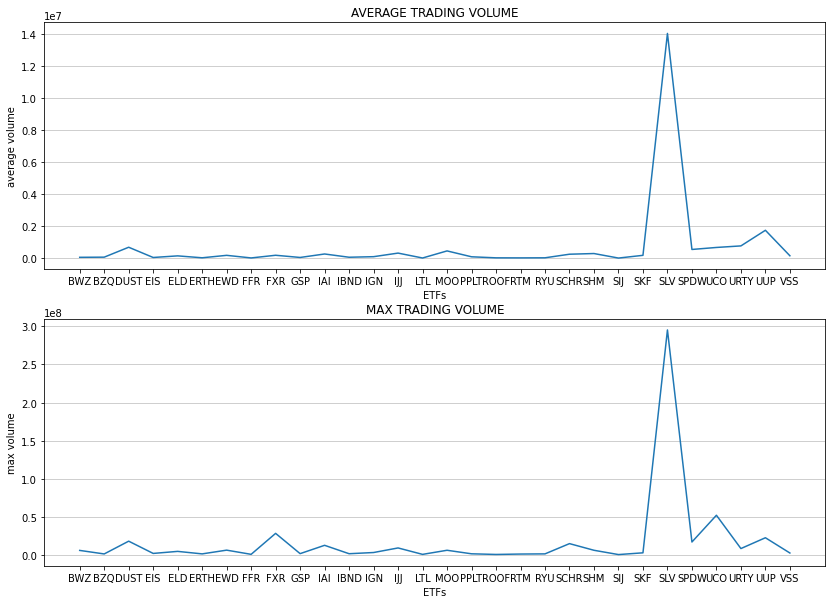

In [11]:
#plot
plt.figure(figsize=(14, 10))

plt.subplot(2,1,1)
plt.title("AVERAGE TRADING VOLUME")
plt.plot(list(etf_list), avg)
plt.xlabel('ETFs')
plt.ylabel('average volume')
plt.grid(axis='y', alpha=0.75)#plot grid lines

plt.subplot(2,1,2)
plt.title("MAX TRADING VOLUME")
plt.plot(list(etf_list), maxi)
plt.xlabel('ETFs')
plt.ylabel('max volume')
plt.grid(axis='y', alpha=0.75)#plot grid lines

#### What is "SLV"? Why is it so different?

In [12]:
ETF_info[ETF_info.fund_symbol == 'SLV']

,fund_symbol,quote_type,region,fund_short_name,fund_long_name,currency,fund_category,fund_family,exchange_code,exchange_name,...,fund_stdev_5years,fund_sharpe_ratio_5years,fund_treynor_ratio_5years,fund_alpha_10years,fund_beta_10years,fund_mean_annual_return_10years,fund_r_squared_10years,fund_stdev_10years,fund_sharpe_ratio_10years,fund_treynor_ratio_10years
2279,SLV,ETF,US,BTS Tactical Fixed Income Fund,BTS Tactical Fixed Income Fund Class I,USD,NaN,BTS,PCX,NYSEArca,...,28.12,0.31,5.03,5.61,1.28,0.07,35.48,30.19,0.01,-3.21


In [13]:
#check if all ETFs have data from 2011-12-01 to 2021-11-30 (ten years)

start = []#check start date '2011-12-01'
end = []#check end date '2021-11-30'
for i in etf_list:
    if len(data[(data.fund_symbol == i)&(data.price_date == '2011-12-01')]) == 1:
        start.append(1)
    else:
        start.append(0)
    if len(data[(data.fund_symbol == i)&(data.price_date == '2021-11-30')]) == 1:
        end.append(1)
    else:
        end.append(0)
print(start,end)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Comment:
We can see that all these 30 ETFs have consecutive data from 2011-12-01 to 2021-11-30, that's a good news, we can align those data and make predictions!

In [14]:
a = data[(data.fund_symbol == i)&(data.price_date == '2011-12-01')].index[0]
#data.iloc[a:,:]
a

106467

In [15]:
#split into 30 datasets and store in etf, each element contains the full data of one ETF
etf = []

for i in etf_list:
    start_index = data[(data.fund_symbol == i)&(data.price_date == '2011-12-01')].index[0]
    end_index = data[(data.fund_symbol == i)&(data.price_date == '2021-11-30')].index[0]
    temp = data.iloc[start_index:end_index+1,:]
    temp.reset_index(inplace = True, drop = True)
    etf.append(temp)
etf[0]


,fund_symbol,price_date,open,high,low,close,adj_close,volume
0,BWZ,2011-12-01,37.01,37.03,36.77,36.86,35.47,27300
1,BWZ,2011-12-02,37.20,37.20,36.66,36.79,35.41,65400
2,BWZ,2011-12-05,37.67,37.67,36.75,36.85,35.46,19200
3,BWZ,2011-12-06,37.12,37.12,36.78,36.97,35.58,13300
4,BWZ,2011-12-07,36.81,37.03,36.81,36.91,35.52,45500
...,...,...,...,...,...,...,...,...
2511,BWZ,2021-11-23,30.35,30.39,30.22,30.34,30.34,19200
2512,BWZ,2021-11-24,30.26,30.27,30.22,30.26,30.26,10600
2513,BWZ,2021-11-26,30.30,30.50,30.30,30.47,30.47,16400
2514,BWZ,2021-11-29,30.51,30.51,30.34,30.41,30.41,9200


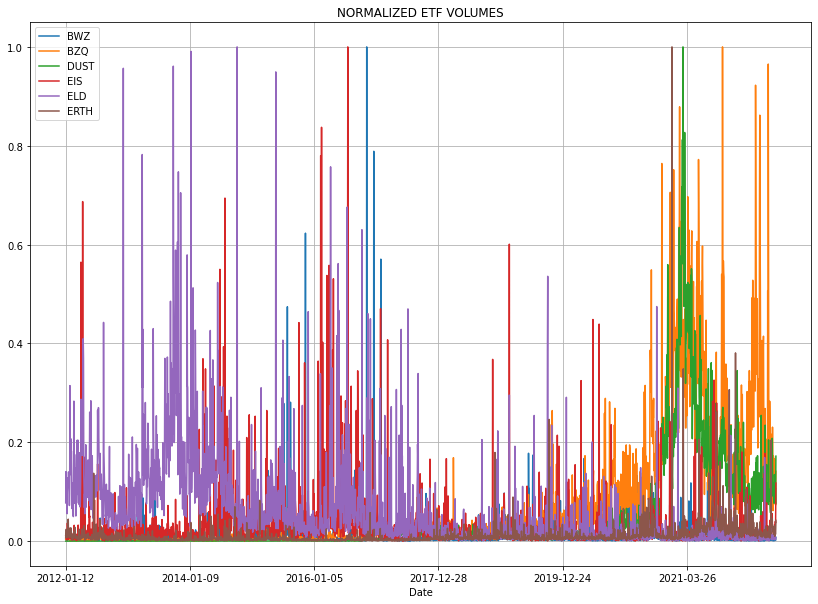

In [16]:
#plot the time series of volumes for first 6 ETFs (normalized)

def plot_volumes_normalized(etf):#function that plots normalized volumes
    #fig configuration
    fig, ax = plt.subplots(figsize=(14, 10))
    plt.title("NORMALIZED ETF VOLUMES")
    ax.set_xlabel('Date')
    plt.xticks(range(0,2500,440),['2012-01-12', '2014-01-09', '2016-01-05', '2017-12-28', '2019-12-24', '2021-03-26'])
    
    for i in range(6):
        #normalize the data
        sc = MinMaxScaler(feature_range = (0, 1))#ranging from 0-1
        volume_scaled = pd.DataFrame(sc.fit_transform(etf[i].iloc[:,[-1]]))
        
        #plot
        y = np.arange(0,2516,1)
        ax.plot(y, volume_scaled[0], label=etf_list[i])
    
    #refinement
    plt.legend()
    plt.grid(axis='both')
    plt.show()

plot_volumes_normalized(etf)

### Comment:
We can see that after doing min-max-scaling, the y-dimension is rescaled and becomes more balanced.

# PREDICTION 1: MULTILAYER PERCEPTRON

In [17]:
#split train & test data

train = []#contains train data of 30 ETFs
test = []#contains test data of 30 ETFs

for i in range(30):
    train.append(etf[i].iloc[:2013,:])#80% of the data
    temp = etf[i].iloc[2013:,:]#20% of the data
    temp.reset_index(inplace = True, drop = True)
    test.append(temp)
print(train[0])
print(test[0])

     fund_symbol  price_date   open   high    low  close  adj_close  volume
0            BWZ  2011-12-01  37.01  37.03  36.77  36.86      35.47   27300
1            BWZ  2011-12-02  37.20  37.20  36.66  36.79      35.41   65400
2            BWZ  2011-12-05  37.67  37.67  36.75  36.85      35.46   19200
3            BWZ  2011-12-06  37.12  37.12  36.78  36.97      35.58   13300
4            BWZ  2011-12-07  36.81  37.03  36.81  36.91      35.52   45500
...          ...         ...    ...    ...    ...    ...        ...     ...
2008         BWZ  2019-11-25  30.31  30.44  30.30  30.33      30.27   24000
2009         BWZ  2019-11-26  30.34  30.47  30.32  30.34      30.28   48700
2010         BWZ  2019-11-27  30.36  30.44  30.33  30.37      30.31   12200
2011         BWZ  2019-11-29  30.25  30.42  30.25  30.34      30.28    5200
2012         BWZ  2019-12-02  30.36  30.58  30.36  30.44      30.39   31000

[2013 rows x 8 columns]
    fund_symbol  price_date   open   high    low  close  adj_cl

### Comment:
We split into train and test sets. Train set contains 80% of the data, while test set 20%. We store them in two lists 'train' and 'test', each list has 30 elements, each element is the train/test data of the corresponding ETFs.

In [18]:
#multi-layer perceptron

predicted_mlp = []#store each ETF's prediced open prices

for i in range(30):
    y = train[i].iloc[1:,2]
    x = train[i].iloc[:-1,2:]
    clf = MLPRegressor(solver='lbfgs', activation='relu', learning_rate_init=1e-4, alpha=1e-4, max_iter=1000000, hidden_layer_sizes=(32,128,32,64))
    clf.fit(x,y)

    pred = clf.predict(test[i].iloc[:-1,2:])
    predicted_mlp.append(pred.tolist())
predicted_mlp

[[2.8428243069444137,
  2.452978173718981,
  2.038453584629855,
  2.272537705852875,
  2.499949530347641,
  2.6858402755862074,
  2.5942412875127787,
  2.56634756247002,
  2.485702483266215,
  9.002489560765872,
  2.749006749195934,
  25.61864473865547,
  2.2531370531390906,
  2.822143626054532,
  2.5706145846508037,
  4.410159257519927,
  3.6388645910066146,
  7.435382192681692,
  2.241199955702547,
  4.480398399249799,
  2.2993402067079445,
  2.104595177895709,
  2.140505385797957,
  2.207871444163294,
  2.4941286598669934,
  4.9850024140679405,
  2.665245356667475,
  11.315459569094065,
  3.5163022870907583,
  2.7098218632298825,
  2.3839372993085193,
  3.556242430183494,
  2.7519979470911324,
  2.062556494482527,
  2.4211292641265403,
  2.311676960783308,
  2.6593801533487125,
  2.2140878027634074,
  3.056843706382216,
  2.8118149302628184,
  2.9821524149555274,
  2.526783876404244,
  2.104257769560951,
  2.094589086539719,
  2.2135955242590684,
  2.376341803385577,
  2.26246218083

In [19]:
#calculate R_OOS for multi-layer perceptron
R_OOS_mlp = []#store each stock's R_OOS
removed = 0#store the removed values equal to 0
for j in range(30):
    predicted = predicted_mlp[j]
    real = test[j].iloc[1:,2].tolist()
    r_oos = []
    for k in range(len(predicted_mlp[0])):
        if real[k] == 0:
            removed += 1
            continue
        a = (predicted[k] - real[k])/(real[k]*real[k])
        r_oos.append(a)
    r_oos = np.array(r_oos).sum()/(len(predicted_mlp[0])-removed)
    R_OOS_mlp.append(r_oos)
R_OOS_mlp

[-0.02855247397581524,
 0.0014412015052486199,
 0.10985893510902951,
 0.000340596491081263,
 0.001148764066070704,
 7.978148958883109e-05,
 0.0015871409439692703,
 0.0007035839502733599,
 -0.008394796763645927,
 -0.0010164027361374273,
 0.00023194874418429448,
 6.320939383449481e-05,
 -2.3302270974446076e-05,
 0.00017970053911520322,
 0.0007559272860918135,
 0.0001416892252782021,
 8.288326782930484e-06,
 -0.0002624810912901083,
 1.2310211820750761e-05,
 5.043280787187718e-05,
 -0.004822357742867036,
 0.00017284683072898104,
 0.0025072952198063854,
 -0.0031983771479863025,
 0.04808501551035685,
 9.566860212570644e-05,
 0.2174049203776504,
 7.259859865733396e-05,
 -0.017217733571678544,
 0.00010098778743865078]

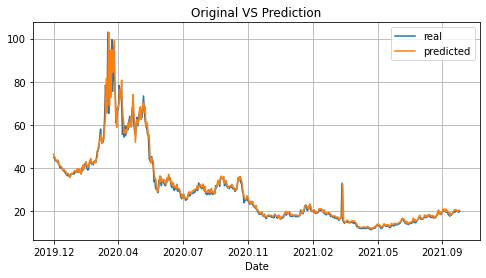

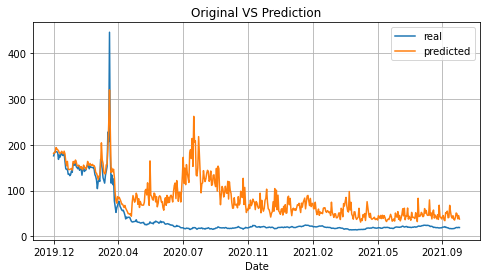

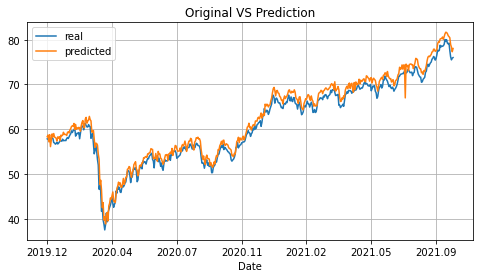

In [20]:
#plot predicted VS real stock prices

for i in range(1,4):#we just print the first three ETFs
    plt.figure(figsize=(8,4))
    plt.subplot(3,1,i)
    real = test[i].iloc[1:,2].tolist()
    pred = predicted_mlp[i]

    
    
    ax = plt.subplot()
    
    plt.title("Original VS Prediction")
    ax.set_xlabel('Date')
    plt.xticks(range(0,520,80),['2019.12', '2020.04', '2020.07', '2020.11', '2021.02', '2021.05', '2021.09'])
    
    #plot
    y = np.arange(0,502,1)
    ax.plot(y, real, label='real')
    
    ax.plot(y, pred, label='predicted')
    
    plt.legend()
    plt.grid(axis='both')
    
    plt.show()

# PREDICTION 2: LSTM

In [21]:
#min-max scaling (for MLP we don't use rescaling, only for LSTM)

etf_scaled = []#store scaled dataframe
scaler = []#store 30 scalers

for i in range(30):#rescaling for each ETF data
    sc = MinMaxScaler(feature_range = (0, 1))#ranging from 0-1
    scaler.append(sc)
    scaled_data = pd.DataFrame(sc.fit_transform(etf[i].iloc[:,2:]))
    scaled_data.columns = ['open','high','low','close','adj_close','volume']
    scaled_data = pd.concat([etf[i].iloc[:,:2], scaled_data], axis=1)
    etf_scaled.append(scaled_data)

etf_scaled[0]


,fund_symbol,price_date,open,high,low,close,adj_close,volume
0,BWZ,2011-12-01,0.931748,0.927355,0.948498,0.951389,0.889594,0.004707
1,BWZ,2011-12-02,0.951396,0.946652,0.936695,0.943287,0.881980,0.011475
2,BWZ,2011-12-05,1.000000,1.000000,0.946352,0.950231,0.888325,0.003268
3,BWZ,2011-12-06,0.943123,0.937571,0.949571,0.964120,0.903553,0.002220
4,BWZ,2011-12-07,0.911065,0.927355,0.952790,0.957176,0.895939,0.007940
...,...,...,...,...,...,...,...,...
2511,BWZ,2021-11-23,0.243020,0.173666,0.245708,0.196759,0.238579,0.003268
2512,BWZ,2021-11-24,0.233713,0.160045,0.245708,0.187500,0.228426,0.001741
2513,BWZ,2021-11-26,0.237849,0.186152,0.254292,0.211806,0.255076,0.002771
2514,BWZ,2021-11-29,0.259566,0.187287,0.258584,0.204861,0.247462,0.001492


#### Now we want to predict the price using the data from past 50 days, hence we need to reshape the input data into (2466 x 50 x 6) from (2516 x 6). This is because every 50 days forms one input, there are only 2466 groups of consecutive 50 days in 2516 days.

In [22]:
#split scaled train & test data

train1 = []#contains train data of 30 ETFs
test1 = []#contains test data of 30 ETFs

for i in range(30):
    train1.append(etf_scaled[i].iloc[:2013,:])#80% of the data
    temp = etf_scaled[i].iloc[2013:,:]#20% of the data
    temp.reset_index(inplace = True, drop = True)
    test1.append(temp)
print(train1[0])
print(test1[0])

     fund_symbol  price_date      open      high       low     close  \
0            BWZ  2011-12-01  0.931748  0.927355  0.948498  0.951389   
1            BWZ  2011-12-02  0.951396  0.946652  0.936695  0.943287   
2            BWZ  2011-12-05  1.000000  1.000000  0.946352  0.950231   
3            BWZ  2011-12-06  0.943123  0.937571  0.949571  0.964120   
4            BWZ  2011-12-07  0.911065  0.927355  0.952790  0.957176   
...          ...         ...       ...       ...       ...       ...   
2008         BWZ  2019-11-25  0.238883  0.179342  0.254292  0.195602   
2009         BWZ  2019-11-26  0.241986  0.182747  0.256438  0.196759   
2010         BWZ  2019-11-27  0.244054  0.179342  0.257511  0.200231   
2011         BWZ  2019-11-29  0.232678  0.177072  0.248927  0.196759   
2012         BWZ  2019-12-02  0.244054  0.195233  0.260730  0.208333   

      adj_close    volume  
0      0.889594  0.004707  
1      0.881980  0.011475  
2      0.888325  0.003268  
3      0.903553  0.0022

In [25]:
# reshape the data into 50 x 6 by creating a list for each ETF(all lists are stored in etf_reshaped), each element has a 50 x 6 array

#function for reshaping
def createXY(dataset,n_past):  #n_past means how many past data you want to include
    dataX = []#store X
    dataY = []#store Y
    for i in range(n_past, dataset.shape[0]):          
        dataX.append(dataset.iloc[(i-n_past):i, 2:])          
        dataY.append(dataset.iloc[i,2])  
        
    return np.array(dataX),np.array(dataY)




In [29]:
#for testing we see the shape of training data of the first ETF
trainX, trainY = createXY(train1[0],50)
testX, testY = createXY(test1[0],50)
print(trainX.shape,trainY.shape)
#the shape is correct!

(1963, 50, 6) (1963,)


In [36]:
#predict using LSTM

time_step = 50 #use past 50 days' prices to predict price of the next day
input_size = 6 #use 6 variables
batch_size = 4
epochs = 50


def build_model():#build LSTM model
    model = Sequential()
    model.add(LSTM(units = 128, input_shape = (time_step, input_size)))
    model.add(Dropout(0.2))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

#train model
model = build_model()
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.25, shuffle=True)

#evaluate model
train_score = model.evaluate(trainX, trainY, verbose=0)
validation_score = model.evaluate(testX, testY, verbose=0)
print(validation_score)

#predict
predict_validation = model.predict(testX)


Epoch 1/50
368/368 [==============================] - 12s 27ms/step - loss: 0.0070 - val_loss: 3.5674e-04
Epoch 2/50
368/368 [==============================] - 9s 24ms/step - loss: 0.0029 - val_loss: 2.3983e-04
Epoch 3/50
368/368 [==============================] - 9s 24ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 4/50
368/368 [==============================] - 9s 26ms/step - loss: 0.0023 - val_loss: 3.0959e-04
Epoch 5/50
368/368 [==============================] - 9s 26ms/step - loss: 0.0024 - val_loss: 2.5307e-04
Epoch 6/50
368/368 [==============================] - 9s 24ms/step - loss: 0.0020 - val_loss: 1.5489e-04
Epoch 7/50
368/368 [==============================] - 9s 24ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 8/50
368/368 [==============================] - 9s 24ms/step - loss: 0.0018 - val_loss: 4.7093e-04
Epoch 9/50
368/368 [==============================] - 9s 24ms/step - loss: 0.0016 - val_loss: 4.0741e-04
Epoch 10/50
368/368 [==============================] - 9s 24ms

In [37]:
predict_validation

array([[0.24343807],
       [0.24265903],
       [0.23520207],
       [0.22547954],
       [0.20891076],
       [0.22098267],
       [0.22201085],
       [0.2313382 ],
       [0.22667837],
       [0.2385658 ],
       [0.2538241 ],
       [0.280874  ],
       [0.29132336],
       [0.29026827],
       [0.3031534 ],
       [0.31417793],
       [0.3362469 ],
       [0.29708618],
       [0.29404986],
       [0.227646  ],
       [0.2008841 ],
       [0.1930309 ],
       [0.17853555],
       [0.1411989 ],
       [0.09050423],
       [0.07338518],
       [0.09935099],
       [0.09655291],
       [0.13913462],
       [0.18293756],
       [0.20983198],
       [0.19554415],
       [0.19226319],
       [0.16787943],
       [0.15947804],
       [0.1458078 ],
       [0.13660166],
       [0.17432186],
       [0.1709168 ],
       [0.18302876],
       [0.18990251],
       [0.20481801],
       [0.17445377],
       [0.16739044],
       [0.18341526],
       [0.17805567],
       [0.1616098 ],
       [0.163

In [39]:
predict = [i[0] for i in predict_validation]
predict

[0.24343807,
 0.24265903,
 0.23520207,
 0.22547954,
 0.20891076,
 0.22098267,
 0.22201085,
 0.2313382,
 0.22667837,
 0.2385658,
 0.2538241,
 0.280874,
 0.29132336,
 0.29026827,
 0.3031534,
 0.31417793,
 0.3362469,
 0.29708618,
 0.29404986,
 0.227646,
 0.2008841,
 0.1930309,
 0.17853555,
 0.1411989,
 0.09050423,
 0.07338518,
 0.09935099,
 0.09655291,
 0.13913462,
 0.18293756,
 0.20983198,
 0.19554415,
 0.19226319,
 0.16787943,
 0.15947804,
 0.1458078,
 0.13660166,
 0.17432186,
 0.1709168,
 0.18302876,
 0.18990251,
 0.20481801,
 0.17445377,
 0.16739044,
 0.18341526,
 0.17805567,
 0.1616098,
 0.16374016,
 0.17251623,
 0.17823479,
 0.1867787,
 0.19762242,
 0.20256865,
 0.21228546,
 0.2163324,
 0.20682162,
 0.19869626,
 0.18514973,
 0.19167411,
 0.20523697,
 0.19509828,
 0.19305518,
 0.1913814,
 0.189374,
 0.18744418,
 0.19843686,
 0.20935917,
 0.2206096,
 0.21886909,
 0.20371783,
 0.22758502,
 0.22378394,
 0.23776609,
 0.24414933,
 0.25751927,
 0.26846457,
 0.27119675,
 0.2814011,
 0.28316

In [44]:
testY = testY.tolist()
len(testY)

[0.22440537745604994,
 0.22026887280248175,
 0.21096173733195434,
 0.19441571871768337,
 0.19441571871768337,
 0.1995863495346435,
 0.2088934850051709,
 0.20579110651499466,
 0.21923474663909026,
 0.22233712512926562,
 0.24095139607032046,
 0.2626680455015511,
 0.26680455015511884,
 0.2750775594622543,
 0.3061013443640128,
 0.31747673216132366,
 0.2978283350568769,
 0.28128231644260593,
 0.24922440537745638,
 0.22026887280248175,
 0.19544984488107575,
 0.17580144777662898,
 0.1292657704239919,
 0.10651499482936932,
 0.0,
 0.06204756980351611,
 0.07962771458117901,
 0.08066184074457095,
 0.13753877973112738,
 0.14581178903826286,
 0.15822130299896608,
 0.17063081695966886,
 0.1323681489141677,
 0.1540847983453979,
 0.13443640124095158,
 0.10341261633919352,
 0.12823164426059996,
 0.143743536711479,
 0.15615305067218221,
 0.1737331954498451,
 0.18717683557393983,
 0.13443640124095158,
 0.14167528438469512,
 0.15925542916235802,
 0.13340227507755964,
 0.143743536711479,
 0.139607032057911

In [42]:
len(predict)

453

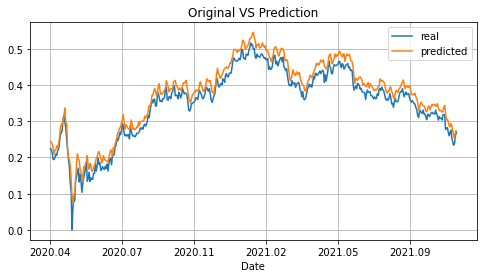

In [46]:
#plot predicted VS real stock prices

for i in range(1):#we just print the first three ETFs
    plt.figure(figsize=(8,4))
    #plt.subplot(3,1,i)
    real = testY
    pred = predict
    
    ax = plt.subplot()
    
    plt.title("Original VS Prediction")
    ax.set_xlabel('Date')
    plt.xticks(range(0,470,80),['2020.04', '2020.07', '2020.11', '2021.02', '2021.05', '2021.09'])
    
    #plot
    y = np.arange(0,len(testY),1)
    ax.plot(y, real, label='real')
    
    ax.plot(y, pred, label='predicted')
    
    plt.legend()
    plt.grid(axis='both')
    
    plt.show()

# TESTING

Epoch 1/10
368/368 [==============================] - 13s 30ms/step - loss: 0.0061 - val_loss: 3.3312e-04
Epoch 2/10
368/368 [==============================] - 9s 25ms/step - loss: 0.0035 - val_loss: 2.7943e-04
Epoch 3/10
368/368 [==============================] - 9s 25ms/step - loss: 0.0030 - val_loss: 6.4820e-04
Epoch 4/10
368/368 [==============================] - 9s 25ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 5/10
368/368 [==============================] - 9s 25ms/step - loss: 0.0022 - val_loss: 1.8629e-04
Epoch 6/10
368/368 [==============================] - 9s 25ms/step - loss: 0.0022 - val_loss: 2.6163e-04
Epoch 7/10
368/368 [==============================] - 9s 25ms/step - loss: 0.0019 - val_loss: 1.7781e-04
Epoch 8/10
368/368 [==============================] - 9s 25ms/step - loss: 0.0017 - val_loss: 7.0087e-04
Epoch 9/10
368/368 [==============================] - 9s 25ms/step - loss: 0.0017 - val_loss: 1.3617e-04
Epoch 10/10
368/368 [==============================] - 9s 

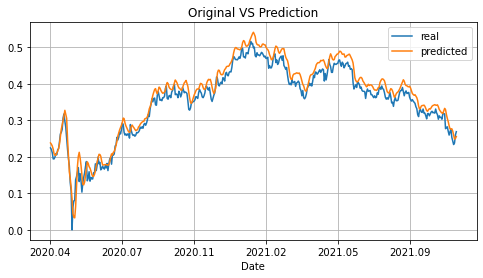

In [51]:
#split scaled train & test data

train2 = []#contains train data of 30 ETFs
test2 = []#contains test data of 30 ETFs

for i in range(30):
    train2.append(etf_scaled[i].iloc[:2013,[2,3,4,5,7]])#80% of the data
    temp = etf_scaled[i].iloc[2013:,[2,3,4,5,7]]#20% of the data
    temp.reset_index(inplace = True, drop = True)
    test2.append(temp)

def createXY1(dataset,n_past):  #n_past means how many past data you want to include
    dataX = []#store X
    dataY = []#store Y
    for i in range(n_past, dataset.shape[0]):          
        dataX.append(dataset.iloc[(i-n_past):i, :])          
        dataY.append(dataset.iloc[i,0])  
        
    return np.array(dataX),np.array(dataY)

trainX, trainY = createXY1(train2[0],50)
testX, testY = createXY1(test2[0],50)

time_step = 50 #use past 50 days' prices to predict price of the next day
input_size = 5 #use 6 variables
batch_size = 4
epochs = 10


def build_model():#build LSTM model
    model = Sequential()
    model.add(LSTM(units = 128, input_shape = (time_step, input_size)))
    model.add(Dropout(0.2))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

#train model
model = build_model()
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.25, shuffle=True)

#evaluate model
train_score = model.evaluate(trainX, trainY, verbose=0)
validation_score = model.evaluate(testX, testY, verbose=0)
print(validation_score)

#predict
predict_validation = model.predict(testX)

predict = [i[0] for i in predict_validation]

testY = testY.tolist()

for i in range(1):#we just print the first three ETFs
    plt.figure(figsize=(8,4))
    #plt.subplot(3,1,i)
    real = testY
    pred = predict
    
    ax = plt.subplot()
    
    plt.title("Original VS Prediction")
    ax.set_xlabel('Date')
    plt.xticks(range(0,470,80),['2020.04', '2020.07', '2020.11', '2021.02', '2021.05', '2021.09'])
    
    #plot
    y = np.arange(0,len(testY),1)
    ax.plot(y, real, label='real')
    
    ax.plot(y, pred, label='predicted')
    
    plt.legend()
    plt.grid(axis='both')
    
    plt.show()

In [50]:
trainX.shape

(1963, 50, 3)

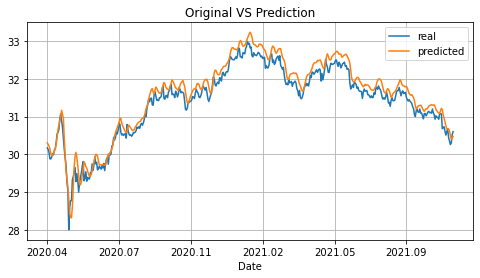

In [71]:
sc = scaler[0]

testY = pd.Series(testY)
a = pd.concat([testY, testY, testY, testY, testY, testY], axis=1)
predict = pd.Series(predict)
b = pd.concat([predict, predict, predict, predict, predict, predict], axis=1)

a = pd.DataFrame(sc.inverse_transform(a)).iloc[:,0]
b = pd.DataFrame(sc.inverse_transform(b)).iloc[:,0]

for i in range(1):#we just print the first three ETFs
    plt.figure(figsize=(8,4))
    #plt.subplot(3,1,i)
    real = a
    pred = b
    
    ax = plt.subplot()
    
    plt.title("Original VS Prediction")
    ax.set_xlabel('Date')
    plt.xticks(range(0,470,80),['2020.04', '2020.07', '2020.11', '2021.02', '2021.05', '2021.09'])
    
    #plot
    y = np.arange(0,len(testY),1)
    ax.plot(y, real, label='real')
    
    ax.plot(y, pred, label='predicted')
    
    plt.legend()
    plt.grid(axis='both')
    
    plt.show()
    